In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import os
import csv 

import keras
import tensorflow as tf
from keras import backend
from keras.backend import set_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, LeakyReLU, Conv2DTranspose, ReLU
from tensorflow.keras.optimizers import Adam
from keras.layers import Reshape
from keras import layers
import datetime

from keras import initializers


config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # fraction of memory
config.gpu_options.visible_device_list = "0"

set_session(tf.compat.v1.Session(config=config))

In [2]:
path = '/kaggle/input/face-mask-dataset-1'
xname = '/kaggle/input/face-mask-dataset-1/celebA_real_with_mask3.pickle'
yname = '/kaggle/input/face-mask-dataset-1/celebA_real_with_out_mask3.pickle'
pickle_in = open(os.path.join(path,xname),"rb")
x = pickle.load(pickle_in)

pickle_in = open(os.path.join(path,yname),"rb")
y = pickle.load(pickle_in)

print(x.shape)
print(y.shape)
print(type(x))

(10006, 64, 64, 1)
(10006, 64, 64, 1)
<class 'numpy.ndarray'>


In [3]:
fields = ["Gan Loss", "Disc loss", "Gen Loss" , "Test Gan Loss", "Test Disc Loss"]
rows = []
print(rows)

[]


(10006, 64, 64, 1)
(10006, 64, 64, 1)


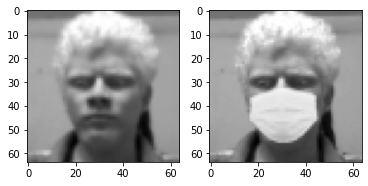

In [4]:
#Resize the image from 200 * 200 to 64 * 64

from skimage.transform import resize
x = resize(x, (len(x),64, 64,1), anti_aliasing=False)
y = resize(y, (len(y),64,64,1), anti_aliasing=False)

# Print the shape after resize
print(x.shape)
print(y.shape)

#Draw the image to be sure occluded image is the same as the ground truth one
fig=plt.figure(figsize=(6, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(x[4,:,:,0],cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(y[4,:,:,0],cmap="gray")


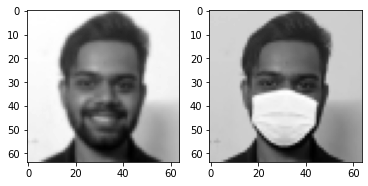

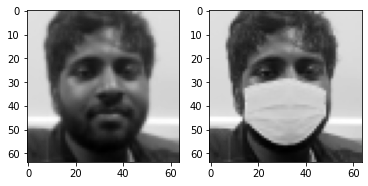

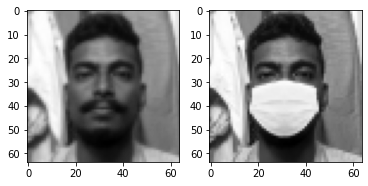

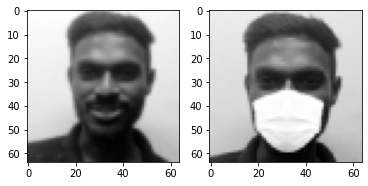

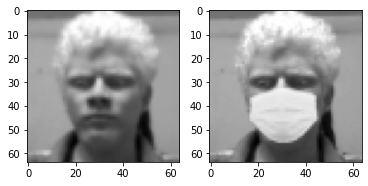

In [5]:
for i in range(5):
    fig=plt.figure(figsize=(6, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(x[i,:,:,0],cmap="gray")
    fig.add_subplot(1, 2, 2)
    plt.imshow(y[i,:,:,0],cmap="gray")

In [6]:
print(x.shape)
print(y.shape)

(10006, 64, 64, 1)
(10006, 64, 64, 1)


In [7]:
#print pixel values to be sure occluded and ground truth images are aligned
print(x[2,50:52,50:52,0])
print(y[2,50:52,50:52,0])

[[0.45588235 0.46078431]
 [0.44803922 0.46862745]]
[[0.4627451  0.45882353]
 [0.45098039 0.46666667]]


In [8]:
#Here is the function to create a generator. 
def creategen():
  generator = Sequential()


  generator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))


  generator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  
  generator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = "tanh"))
  

  return generator

generator = creategen()


In [9]:
#Here is the function to create a discriminator. 
def createdisc():
  discriminator = Sequential()

  discriminator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))


  discriminator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Flatten())
  discriminator.add(Dense(1))
  
  return discriminator


discriminator = createdisc()


In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [11]:
# Learning rate of discriminator is advised to be the double of the generator. 
# train the generator two times in each step of training. First is with Gan loss, second is with L2 loss.
# That is why we use x4 learning rate in discriminator.

opt_disc = Adam(lr=0.00004)
discriminator.trainable = True
discriminator.compile(loss = "binary_crossentropy", optimizer = opt_disc)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)      

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
opt_gen = Adam(lr=0.00002)
generator.compile(loss="mean_squared_error", optimizer = opt_gen)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [13]:
print(x[0])

[[[0.83137255]
  [0.83137255]
  [0.83137255]
  ...
  [0.80392157]
  [0.80392157]
  [0.80392157]]

 [[0.83137255]
  [0.83137255]
  [0.83137255]
  ...
  [0.80392157]
  [0.80392157]
  [0.80392157]]

 [[0.82745098]
  [0.83039216]
  [0.83137255]
  ...
  [0.80392157]
  [0.80392157]
  [0.80392157]]

 ...

 [[0.78529412]
  [0.78431373]
  [0.78529412]
  ...
  [0.61862745]
  [0.63137255]
  [0.64117647]]

 [[0.78431373]
  [0.78039216]
  [0.78039216]
  ...
  [0.61764706]
  [0.63137255]
  [0.64117647]]

 [[0.78431373]
  [0.78039216]
  [0.78039216]
  ...
  [0.61764706]
  [0.63137255]
  [0.64313725]]]


In [14]:
#Here is the function to create a GAN model.

def creategan(generator,discriminator):
  gan = Sequential()
  gan.add(generator)
  discriminator.trainable = False
  gan.add(discriminator)
  return(gan)

gan = creategan(generator,discriminator)

In [15]:
opt_gan = Adam(lr=0.00001)
gan.compile(loss = "binary_crossentropy", optimizer = opt_gan)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         2054208   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1044225   
Total params: 3,098,433
Trainable params: 2,052,928
Non-trainable params: 1,045,505
_________________________________________________________________


In [16]:
# This is to save models. It saves both the architectures and the weights.

def save_models(gan,discriminator,generator,path,epoch):
  datenow = str(datetime.datetime.now().strftime('%m-%d-%H:%M'))
  gan.save_weights(os.path.join(path,"{0}_wgan_{1}.h5".format(epoch,datenow)))
  gan.save(os.path.join(path,"{0}_mgan_{1}.h5".format(epoch,datenow)))


  discriminator.save_weights(os.path.join(path,"{0}_wd_{1}.h5".format(epoch,datenow)))
  discriminator.save(os.path.join(path,"{0}_md_{1}.h5".format(epoch,datenow)))


  generator.save_weights(os.path.join(path,"{0}_wg_{1}.h5".format(epoch,datenow)))
  generator.save(os.path.join(path,"{0}_mg_{1}.h5".format(epoch,datenow)))
  


In [17]:
def test(x,y):
  gan_inp_t = x  
  gan_label_t = np.ones([len(gan_inp_t)])
  gan_predict_t = None
  
  disc_inp_t = None


  disc_label_t = np.zeros([len(gan_inp_t)*2])
  disc_label_t[len(gan_inp_t):] = 1
  
  disc_predict_t = None
  

  gen_predict_t = generator.predict(gan_inp_t)


  disc_inp_t = np.concatenate((gen_predict_t,y), axis = 0)
  disc_predict_t = discriminator.predict(disc_inp_t)

  d_loss_t = discriminator.test_on_batch(disc_inp_t,disc_label_t)

  gan_loss_t = gan.test_on_batch(gan_inp_t,gan_label_t)
  
  return (gan_loss_t, d_loss_t)

In [18]:
# I use isolated mini batches to slow down discriminator:
# I also use smooth/noisy labels proposed by Salimans et al 2016
# Reference: https://github.com/soumith/ganhacks



def train(x,y, nepoch, model_save_path = "./"):

  gen_predict = None
  
  #Initialize the inputs and the labels.
  gan_inp = x 
  gan_inp_size = 64
  gan_label = np.ones(64)
  gan_predict = None
  
  disc_inp = None


  disc_label = np.zeros(64*2)
  disc_label[64:] = 1
  
  disc_predict = None
  

  sess = tf.compat.v1.Session()

  
  
  for epoch in range(nepoch):

    for batch_ctr in range(65):

      #Generator makes a prediction.
      gen_predict = generator.predict(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size])
    

      #Minibatch isolation and label smoothing is done here:
      
      if(epoch%2==0):
        disc_inp = gen_predict
        #disc_label = np.zeros(64) //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=0, scale=0.10, size=64)
      else:
        disc_inp = y[batch_ctr*64:(batch_ctr+1)*64]
        #disc_label = np.ones(64)  //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=1, scale=0.10, size=64)


        
      #Initialize a label variable for generator to use it in training.  
      gen_label = y[batch_ctr*64:(batch_ctr+1)*64]
      
      
      #Do one training step. Also assign the losses to variables. We will print them.
      d_loss = discriminator.train_on_batch(disc_inp,disc_label)


      gan_loss = gan.train_on_batch(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size],
                                    gan_label)

      gen_loss = generator.train_on_batch(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size],gen_label)
      
    
    
    if epoch == nepoch - 1:
      save_models(gan,discriminator,generator, model_save_path,epoch+1)  
      print("MODEL SAVED")
      
    
    # Test images are the images after the 4160th image. It makes 311 test images.
    (tgan,tdisc)= test(x[4160:5000],y[4160:5000])
    
    rows.append([gan_loss,d_loss,gen_loss,tgan,tdisc])
    print("Epoch: {2} Gan Loss: {0}       Disc Loss: {1}        Gen Loss: {3}".format(gan_loss,d_loss,epoch+1,gen_loss))
    print("Epoch: {2} Test Gan Loss: {0}  Test Disc Loss: {1} \n\n\n".format(tgan,tdisc,epoch+1))

In [19]:
# Checking lengths of the input and ground truth arrays. Also checking if normalization is done.
print(len(x),len(y))
print(x.max(),x.min())
print(y.max(),y.min())

10006 10006
1.0 0.0
1.0 0.0


In [20]:
# model_path = "/kaggle/input/weight"

# epoch = 250

# # #generator = creategen()
# generator.load_weights(os.path.join(model_path,"{0}_wg_12-07-12_42.h5".format(epoch)))
# # #discriminator = createdisc()
# discriminator.load_weights(os.path.join(model_path,"{0}_wd_12-07-12_42.h5".format(epoch)))

# # #gan = creategan(generator,discriminator)
# gan.load_weights(os.path.join(model_path,"{0}_wgan_12-07-12_42.h5".format(epoch)))

# print("4400 epochs weight loaded")

In [21]:

model_save_path = './'
batch_size = 64
train(x,y, 500 ,model_save_path)


Epoch: 1 Gan Loss: 15.424948692321777       Disc Loss: 0.028924867510795593        Gen Loss: 0.2998887598514557
Epoch: 1 Test Gan Loss: 15.424947738647461  Test Disc Loss: 7.712474346160889 



Epoch: 2 Gan Loss: 0.8096491098403931       Disc Loss: -0.18944098055362701        Gen Loss: 0.15590685606002808
Epoch: 2 Test Gan Loss: 0.6684168577194214  Test Disc Loss: 0.36051255464553833 



Epoch: 3 Gan Loss: 13.692538261413574       Disc Loss: 0.03449125587940216        Gen Loss: 0.10271596908569336
Epoch: 3 Test Gan Loss: 15.424947738647461  Test Disc Loss: 0.4932669997215271 



Epoch: 4 Gan Loss: 7.282121658325195       Disc Loss: 0.14998508989810944        Gen Loss: 0.06667663156986237
Epoch: 4 Test Gan Loss: 3.551271677017212  Test Disc Loss: 0.16913920640945435 



Epoch: 5 Gan Loss: 15.424948692321777       Disc Loss: 0.2703969180583954        Gen Loss: 0.04291798546910286
Epoch: 5 Test Gan Loss: 15.424947738647461  Test Disc Loss: 7.712474346160889 



Epoch: 6 Gan Loss: 1.412882

In [22]:
filename = "loss.csv"
     
with open(filename, 'w', newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
        
    csvwriter.writerow(fields) 
        
    csvwriter.writerows(rows)

In [23]:
from keras.models import model_from_json
from keras import models 

# Load the trained model
model = models.load_model('/kaggle/input/weight/250_mg_12-07-12_42.h5')

# Convert the model to JSON
model_json = model.to_json()

# Save the JSON format to a file
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [24]:
with open('/kaggle/working/model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    generator = tf.keras.models.model_from_json(json_savedModel)
    generator.load_weights('/kaggle/input/weight/250_wg_12-07-12_42.h5')
    generator.compile(loss="mean_squared_error", optimizer = Adam(lr=0.00002))
print("Model compiled")

Model compiled


In [25]:
# model_path = "/kaggle/input/weight"

# epoch = 2000

# # #generator = creategen()
# generator.load_weights(os.path.join(model_path,"{0}_wg_12-22-01_45.h5".format(epoch)))
# # #discriminator = createdisc()
# discriminator.load_weights(os.path.join(model_path,"{0}_wd_12-22-01_45.h5".format(epoch)))

# # #gan = creategan(generator,discriminator)
# gan.load_weights(os.path.join(model_path,"{0}_wgan_12-22-01_45.h5".format(epoch)))



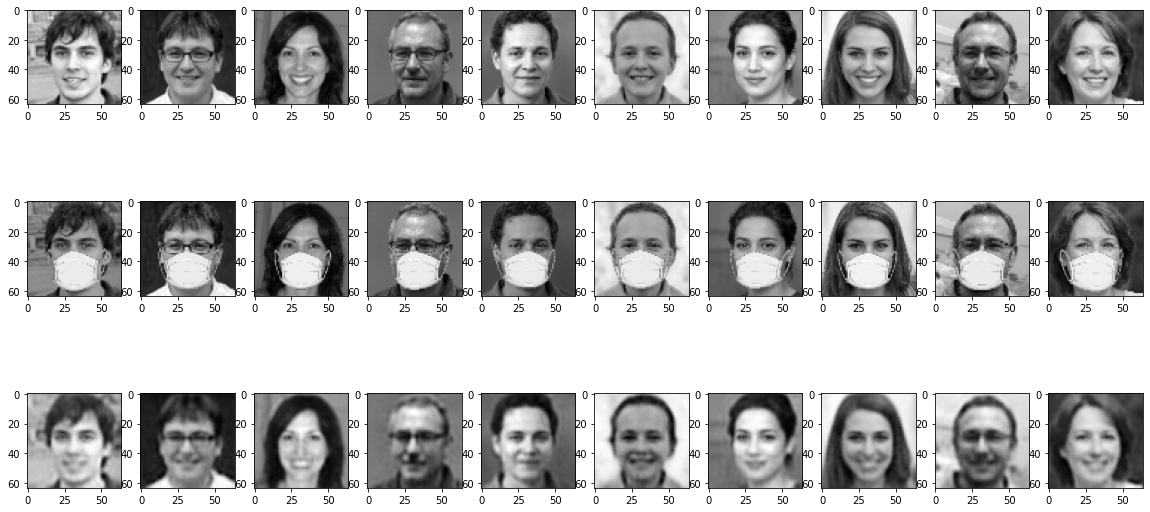

In [26]:
# Making predictions and drawing them.
# First row: Occluded images
# Second row: Ground Truth images
# Third row: Predictions

import datetime
plot_path = "./"

a = 8690
b = 8700
pred=generator.predict(x[a:b])

fig = plt.figure(figsize = (20,10))
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(x[a + ctr],(64,64)),  cmap = "gray")

  

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(y[a + ctr]/255,(64,64)),  cmap = "gray")  


for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  
plt.savefig(os.path.join(plot_path,str(datetime.datetime.now().strftime('%m-%d-%H:%M'))))

Text(0.5, 1.0, '2000 epochs GAN Loss')

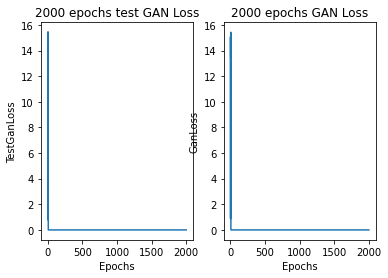

In [27]:
import pandas as pd
from matplotlib import pyplot as plt

figure, axis = plt.subplots(1, 2)

columns = ["Epochs", "TestGanLoss"]
columns1 = ["Epochs", "GanLoss"]

file = "/kaggle/input/loss-6050/2000 epochs loss.csv"

df = pd.read_csv(file , usecols=columns)
axis[0].plot(df.Epochs, df.TestGanLoss)
axis.flat[0].set(xlabel = 'Epochs' , ylabel = 'TestGanLoss')
axis[0].set_title('2000 epochs test GAN Loss')

df1 = pd.read_csv(file, usecols=columns1)
axis[1].plot(df1.Epochs, df1.GanLoss)
axis.flat[1].set(xlabel = 'Epochs' , ylabel = 'GanLoss')

axis[1].set_title('2000 epochs GAN Loss')

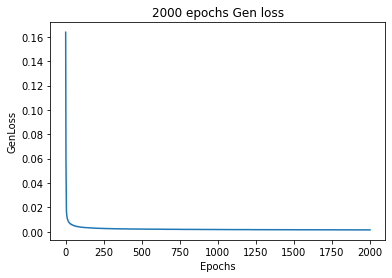

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
columns = ["Epochs", "GenLoss" , "DiscLoss"]
file = "/kaggle/input/loss-6050/2000 epochs loss.csv"
df = pd.read_csv(file, usecols=columns)

fig, ax = plt.subplots()
ax.plot(df.Epochs, df.GenLoss)
ax.set_title("2000 epochs Gen loss")
ax.set(xlabel = 'Epochs' , ylabel = 'GenLoss')
plt.show()

Text(0.5, 1.0, '2000 epochs Disc Loss')

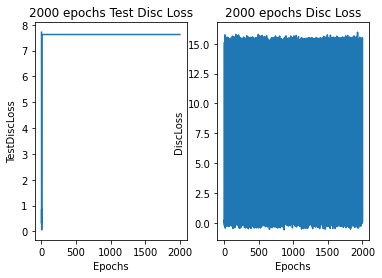

In [29]:

figure, axis = plt.subplots(1, 2)
columns = ["Epochs", "TestDiscLoss"]
columns1 = ["Epochs", "DiscLoss"]
file = "/kaggle/input/loss-6050/2000 epochs loss.csv"

df = pd.read_csv(file, usecols=columns)
axis[0].plot(df.Epochs, df.TestDiscLoss)
axis.flat[0].set(xlabel = 'Epochs' , ylabel = 'TestDiscLoss')
axis[0].set_title('2000 epochs Test Disc Loss')

df1 = pd.read_csv(file, usecols=columns1)
axis[1].plot(df1.Epochs, df1.DiscLoss)
axis.flat[1].set(xlabel = 'Epochs' , ylabel = 'DiscLoss')

axis[1].set_title('2000 epochs Disc Loss')

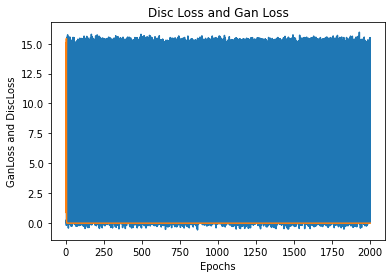

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
columns = ["Epochs", "GanLoss" , "DiscLoss"]
file = "/kaggle/input/loss-6050/2000 epochs loss.csv"
df = pd.read_csv(file, usecols=columns)

fig, ax = plt.subplots()
ax.plot(df.Epochs, df.DiscLoss)
ax.plot(df.Epochs, df.GanLoss)
ax.set_title("Disc Loss and Gan Loss")
ax.set(xlabel = 'Epochs' , ylabel = 'GanLoss and DiscLoss')
plt.show()

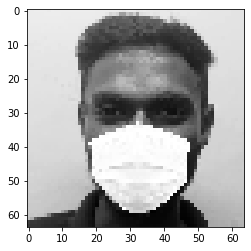

In [31]:
import cv2
import matplotlib.image as mpimg
img = mpimg.imread("/kaggle/input/vijay-2000/Thivagaran_surgical1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img.shape
plt.imshow(img)
from skimage.transform import resize

img = resize(img, (64 , 64), anti_aliasing=False)
plt.imshow(img , cmap = 'gray')

In [32]:
import datetime
plot_path = "./"
img = np.expand_dims(img, axis=-1)
print(img.shape)

(64, 64, 1)


(1, 64, 64, 1)
(1, 64, 64, 1)


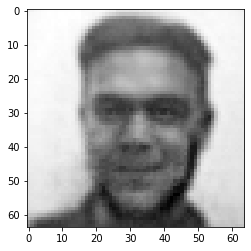

In [33]:
img = np.expand_dims(img, axis=0)
print(img.shape)
pred = generator.predict(img)
print(pred.shape)
plt.imshow(np.reshape(pred, (64,64)), cmap = "gray")

In [34]:
from PIL import Image
import numpy as np

# convert numpy array to image
print(pred.shape)
pred = np.squeeze(pred, axis=0)
pred = np.squeeze(pred, axis=-1)
print(pred.shape)

(1, 64, 64, 1)
(64, 64)


In [35]:

import pickle

# Load the RGB image
print(pred.shape)

file_name='monishh.pickle'
f = open(file_name,'wb')
pickle.dump(pred,f)
f.close()


(64, 64)


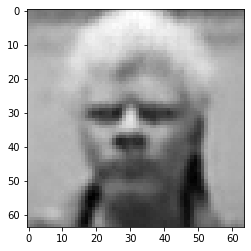

In [36]:
import numpy as np
from PIL import Image as im
 
      
# creating image object of
# above array
actual_img = y[4,:,:,0]
# actual_img = np.expand_dims(actual_img, axis=-1)
# actual_img = np.expand_dims(actual_img, axis=0)

#plt.imshow(np.reshape(y[4,:,:,0], (64,64)), cmap = "gray")
Occlude_img = x[4,:,:,0]
Occlude_img = np.expand_dims(Occlude_img, axis=-1)
Occlude_img = np.expand_dims(Occlude_img, axis=0)
pred_img = generator.predict(Occlude_img)

plt.imshow(np.reshape(pred_img, (64,64)), cmap = "gray")



In [37]:
from skimage.metrics import structural_similarity
# import argparse
# import imutils
import cv2

# pred_img = np.squeeze(pred_img, axis=-1)
# pred_img = np.squeeze(pred_img, axis=0)
print("pred" , pred_img.shape)
print("act" ,actual_img.shape)



pred (1, 64, 64, 1)
act (64, 64)


In [38]:
pred_img = np.squeeze(pred_img , axis = 0)
pred_img = np.squeeze(pred_img , axis = 2)
print(pred_img.shape)

(64, 64)


In [39]:

# # 6. You can print only the score if you want
# score = structural_similarity(pred_img,actual_img, channel_axis=True) #score: 0.0018769083894301646

# print("SSIM: {}".format(score))

In [40]:
# y=generator.predict(x[0:1])

In [41]:
# import numpy
# from numpy import cov
# from numpy import trace
# from numpy import iscomplexobj
# from numpy import asarray
# from numpy.random import randint
# from scipy.linalg import sqrtm
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.datasets.mnist import load_data
# from skimage.transform import resize
# cl = ["imageno","value"]
# val = []
# imageno=[]
# value=[]
 
# # scale an array of images to a new size
# def scale_images(images, new_shape):
#  images_list = list()
#  for image in images:
#  # resize with nearest neighbor interpolation
#      new_image = resize(image, new_shape, 0)
#      # store
#      images_list.append(new_image)
#  return asarray(images_list)
 
# # calculate frechet inception distance
# def calculate_fid(model, images1, images2):
#  # calculate activations
#     act1 = model.predict(images1)
#     act2 = model.predict(images2)
#     # calculate mean and covariance statistics
#     mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
#     mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
#     # calculate sum squared difference between means
#     ssdiff = numpy.sum((mu1 - mu2)**2.0)
#     # calculate sqrt of product between cov
#     covmean = sqrtm(sigma1.dot(sigma2))
#     # check and correct imaginary numbers from sqrt
#     if iscomplexobj(covmean):
#         covmean = covmean.real
#     # calculate score
#     fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
#     return fid
 
# # prepare the inception v3 model
# model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# # define two fake collections of images
# #for i in range(20,50):
# images1=x[8000:8150]
# #images2=x[9200:9300]

# images2=generator.predict(x[8000:8150])
# #images1 = x[5001]
# #images1 = resize(images1, (64 , 64), anti_aliasing=False)
# #images1 = images1.reshape((10,32,32,3))
# #images2 = generator.predict(x[5001:5002])
# #images2 = resize(images2, (64 , 64), anti_aliasing=False)
# #images2 = images2.reshape((10,32,32,3))
# #print('Prepared', images1.shape, images2.shape)
# # convert integer to floating point values
# images1 = images1.astype('float32')
# images2 = images2.astype('float32')
# # resize images
# images1 = scale_images(images1, (299,299,3))
# images2 = scale_images(images2, (299,299,3))
# #print('Scaled', images1.shape, images2.shape)
# # pre-process images
# images1 = preprocess_input(images1)
# images2 = preprocess_input(images2)
# # fid between images1 and images1
# #fid = calculate_fid(model, images1, images1)
# #print('FID (same): %.3f' % fid)
# # fid between images1 and images2
# fid = calculate_fid(model,images1,images2)
# print('FID (different): %.3f' % fid)
# imageno.append(i)
# value.append(fid)
# val.append([imageno,value])
    
# filename = "validate.csv"

# with open(filename, 'w', newline='') as csvfile: 
#     csvwriter = csv.writer(csvfile) 

#     csvwriter.writerow(cl) 

#     csvwriter.writerows(val)

In [42]:
# val.append([imageno,value])
    
# filename = "validate.csv"

# with open(filename, 'w', newline='') as csvfile: 
#     csvwriter = csv.writer(csvfile) 

#     csvwriter.writerow(cl) 

#     csvwriter.writerows(val)

In [43]:
# import pandas
 
# # reading the CSV file
# csvFile = pandas.read_csv('/kaggle/working/validate.csv')
 
# # displaying the contents of the CSV file
# print(csvFile)

In [44]:
# from collections import OrderedDict

# import torch
# from torch import nn, optim

# from ignite.engine import *
# from ignite.handlers import *
# from ignite.metrics import *
# from ignite.utils import *
# from ignite.contrib.metrics.regression import *
# from ignite.contrib.metrics import *

# # create default evaluator for doctests

# def eval_step(engine, batch):
#     return batch

# default_evaluator = Engine(eval_step)

# # create default optimizer for doctests

# param_tensor = torch.zeros([1], requires_grad=True)
# default_optimizer = torch.optim.SGD([param_tensor], lr=0.1)

# # create default trainer for doctests
# # as handlers could be attached to the trainer,
# # each test must define his own trainer using `.. testsetup:`

# def get_default_trainer():

#     def train_step(engine, batch):
#         return batch

#     return Engine(train_step)

# # create default model for doctests

# default_model = nn.Sequential(OrderedDict([
#     ('base', nn.Linear(4, 2)),
#     ('fc', nn.Linear(2, 1))
# ]))

# manual_seed(666)

In [45]:
# metric = FID(num_features=1, feature_extractor=default_model)
# metric.attach(default_evaluator, "fid")
# y_true = x[0]
# y_pred = generator.predict(x[0:1])
# state = default_evaluator.run([[y_pred, y_true]])
# print(state.metrics["fid"])

In [46]:
# # Python code to find Euclidean distance
# # using sum() and square()

# import numpy as np

# # initializing points in
# # numpy arrays
# point1 = x[1]
# point2 = generator.predict(x[1:2])

# # finding sum of squares
# sum_sq = np.sum(np.square(point1 - point2))

# # Doing squareroot and
# # printing Euclidean distance
# print(np.sqrt(sum_sq))
